# ELEC 576 – Introduction to Deep Learning – Assignment 2

Due: 11:00am 10/25/2017

*On my honor, I have neither given nor received any unauthorized aid on this assignment.*

Daniel LeJeune, S01276871
$\newcommand{\grenewcommand}{\renewcommand} \newcommand{\gnewcommand}{\newcommand}$

# Task 1.

## Part (a).

In [1]:
import glob
import os
import re

import numpy as np
from skimage import io

from sklearn.preprocessing import OneHotEncoder

def load_cifar10():
    
    label_re = re.compile(r'.*/(\d)/.*')
    
    train_coll = io.imread_collection('CIFAR10/Train/*/*.png')
    test_coll = io.imread_collection('CIFAR10/Test/*/*.png')
    
    label_encoder = OneHotEncoder(10)
    train_labels = label_encoder.fit_transform(np.array([int(label_re.match(path).group(1)) for path in train_coll.files])[:, None]).toarray()
    test_labels = label_encoder.transform(np.array([int(label_re.match(path).group(1)) for path in test_coll.files])[:, None]).toarray()
    
    train_images = np.stack(train_coll).astype(float) / 255
    test_images = np.stack(test_coll).astype(float) / 255
    
    return train_images, train_labels, test_images, test_labels
    
X_train, y_train, X_test, y_test = load_cifar10()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

/home/wellbeing/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:326: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)


((10000, 28, 28), (10000, 10), (1000, 28, 28), (1000, 10))

## Part (b).

In [2]:
from itertools import product

from matplotlib import pyplot as plt

import tensorflow as tf
from sklearn.model_selection import ParameterSampler, train_test_split

# plt.style.use('notebook')

cifar10_cnn_graph = tf.Graph()

initializer = tf.contrib.layers.xavier_initializer()

def weight(shape):
    return tf.Variable(lambda: initializer(shape=shape))

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=(1, 1, 1, 1), padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')

with cifar10_cnn_graph.as_default():
    
    x = tf.placeholder(tf.float32, shape=[None, 28, 28])
    y = tf.placeholder(tf.float32, shape=[None, 10])
    
    x_one_channel = tf.reshape(x, [-1, 28, 28, 1])
    
    W_conv1 = weight((5, 5, 1, 32))
    b_conv1 = tf.constant(0.1, shape=(32,))
    h_conv1 = tf.nn.relu(conv2d(x_one_channel, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    W_conv2 = weight((5, 5, 32, 64))
    b_conv2 = tf.constant(0.1, shape=(64,))
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    W_fc1 = weight((7 * 7 * 64, 1024))
    b_fc1 = tf.constant(0.1, shape=(1024,))
    h_pool2_flat = tf.reshape(h_pool2, (-1, 7 * 7 * 64))
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    W_fc2 = weight((1024, 10))
    b_fc2 = tf.constant(0.1, shape=(10,))
    y_out = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_out))
    correct_prediction = tf.equal(tf.argmax(y_out, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
def train_eval(X_train, y_train, X_test, y_test, graph, x, y, optimizer, epochs, batch_size, train_metric, eval_metric=None, monitor_vars=None, monitor_iters=100, train_feed_dict={}, eval_feed_dict=None):
    
    sess= tf.Session(graph=graph)
    
    with graph.as_default():
        
        n_train_samples = X_train.shape[0]
        train_step = optimizer.minimize(train_metric)
        if eval_metric is None:
            eval_metric = train_metric
        if eval_feed_dict is None:
            eval_feed_dict = train_feed_dict
        monitor_train = []
        monitor_test = []

        init = tf.global_variables_initializer()
        sess.run(init)

        for n in range(epochs):
            perm = np.arange(n_train_samples)
            np.random.shuffle(perm)

            for i, k in enumerate(range(0, n_train_samples, batch_size)):
                X_batch, y_batch = X_train[perm[k:k+batch_size]], y_train[perm[k:k+batch_size]]
                sess.run(train_step, feed_dict={x: X_batch, y: y_batch, **train_feed_dict})

                if monitor_vars is not None and i % monitor_iters == 0:
                    monitor_train.append((n*n_train_samples + k, sess.run(monitor_vars, feed_dict={x: X_train, y: y_train, **eval_feed_dict})))
                    monitor_test.append((n*n_train_samples + k, sess.run(monitor_vars, feed_dict={x: X_test, y: y_test, **eval_feed_dict})))

        eval_train = sess.run(eval_metric, feed_dict={x: X_train, y: y_train, **eval_feed_dict})
        eval_test = sess.run(eval_metric, feed_dict={x: X_test, y: y_test, **eval_feed_dict})

    if monitor_vars is None:
        return eval_train, eval_test, sess
    else:
        return eval_train, eval_test, sess, monitor_train, monitor_test

n_params = 10
param_search_epochs = 5
batch_size = 50
full_train_epochs = 30
full_train_monitor_iters = 100
    
training_params = ParameterSampler({
    'optimizer': [tf.train.AdamOptimizer(r, b, epsilon=eps) for r, b, eps in product([1e-4, 3e-4, 1e-3], [0.8, 0.9, 0.95], [1e-8, 1e-6, 1e-4])],
    'keep_prob': [0.3, 0.4, 0.5, 0.6, 0.7]
}, n_iter=n_params)

X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.1)

param_search_results = []
for i, params in enumerate(training_params):
    print('Evaluating paramter set %d.' % (i + 1))
    eval_train, eval_test, sess = train_eval(X_train_train, y_train_train, X_train_test, y_train_test, cifar10_cnn_graph, 
                                           x, y, params['optimizer'], param_search_epochs, batch_size, cross_entropy, accuracy,
                                           train_feed_dict={keep_prob: params['keep_prob']}, eval_feed_dict={keep_prob: 1.0})
    sess.close()
    param_search_results.append((params, (eval_train, eval_test)))

best_params = max(param_search_results, key=lambda x: x[1][1])[0]
opt, p = best_params['optimizer'], best_params['keep_prob']

print('Training with best parameters: AdamOptimizer(%g, %g, epsilon=%g), keep_prob=%g' % (opt._lr, opt._beta1, opt._epsilon, p))
eval_train, eval_test, best_session, monitor_train, monitor_test = train_eval(X_train, y_train, X_test, y_test, cifar10_cnn_graph, 
                                       x, y, opt, full_train_epochs, batch_size, cross_entropy, accuracy,
                                       train_feed_dict={keep_prob: p}, eval_feed_dict={keep_prob: 1.0},
                                       monitor_vars=(accuracy, cross_entropy), monitor_iters=full_train_monitor_iters)

print('Train accuracy: %.4f' % eval_train)
print('Test accuracy: %.4f' % eval_test)

iters, train_vals = zip(*monitor_train)
train_accuracies, train_losses = zip(*train_vals)

_, test_vals = zip(*monitor_test)
test_accuracies, test_losses = zip(*test_vals)



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Evaluating paramter set 1.
Evaluating paramter set 2.
Evaluating paramter set 3.
Evaluating paramter set 4.
Evaluating paramter set 5.
Evaluating paramter set 6.
Evaluating paramter set 7.
Evaluating paramter set 8.
Evaluating paramter set 9.
Evaluating paramter set 10.
Training with best parameters: AdamOptimizer(0.001, 0.95, epsilon=1e-08), keep_prob=0.6
Train accuracy: 0.1000
Test accuracy: 0.1000


<Figure size 700x300 with 2 Axes>

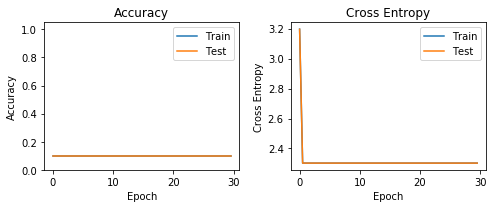

In [3]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(np.array(iters) / X_train.shape[0], train_accuracies, label='Train')
plt.plot(np.array(iters) / X_train.shape[0], test_accuracies, label='Test')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)

plt.subplot(1, 2, 2)
plt.plot(np.array(iters) / X_train.shape[0], train_losses, label='Train')
plt.plot(np.array(iters) / X_train.shape[0], test_losses, label='Test')
plt.title('Cross Entropy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')

plt.tight_layout()
plt.show()

Adding dropout to the first fully connected layer and then optimizing using Adam proved to be a good strategy for training this network. 

## Part (c).

In [ ]:
from matplotlib import patches as patches

W1 = best_session.run(W_conv1)
W1_std = np.std(W1.reshape((-1, W1.shape[-1])), axis=0)
best_indices = list(np.argsort(W1_std)[::-1][:4])
best_styles = ['solid', 'dashed', 'dashdot', 'dotted']

vmax = np.abs(W1).max()
vmin = -vmax

plt.figure(figsize=(7, 3))
for i, j in product(range(4), range(8)):
    k = i*8 + j
    ax = plt.subplot(4, 8, k+1)
    plt.pcolormesh(np.flipud(W1[:, :, 0, k]), vmin=vmin, vmax=vmax, cmap='gray')
    if k in best_indices:
        ax.add_patch(
            patches.Rectangle((0, 0), 5, 5, fill=False, edgecolor='red', linewidth=3, linestyle=best_styles[best_indices.index(k)])
        )
    plt.axis('off')
plt.show()

plt.figure(figsize=(7, 3))
gs = plt.GridSpec(4, 8)
for i, j in product(range(2), range(2)):
    k = i*2 + j
    plt.subplot(gs[i*2:i*2+2, j*4:j*4+2])
    im = X_test[100*k+5, :, :]
    plt.pcolormesh(np.flipud(im), vmin=0, vmax=1, cmap='gray')
    plt.axis('off')
    
    h1 = best_session.run(h_pool1, feed_dict={x: im[None, :, :]})
    for i2, j2 in product(range(2), range(2)):
        k2 = i2*2 + j2
        ax = plt.subplot(gs[i*2+i2, j*4+2+j2])
        h = h1[0, :, :, best_indices[k2]]
        plt.pcolormesh(np.flipud(h), cmap='gray')
        ax.add_patch(
            patches.Rectangle((0, 0), 14, 14, fill=False, edgecolor='red', linewidth=3, linestyle=best_styles[k2])
        )
        plt.axis('off')
plt.show()

The learned convolotional weights do reasonably resemble edge detectors (top). The activations of these filters (bottom) for test images to seem to correspond to areas of the image with edges of different direction.

# Task 2.

Zeiler and Fergus present in this paper a method for visualizing the role of the hidden layers of a deep convolutional network. The method consists of a modification of a previous architecture of theirs, the Deconvolutional Network, which uses the weights of a trained convolutional network and the max-pool mappings of a forward pass to reverse construct an input-space representation of the activations of hidden layer nodes. The resulting visualizations (that is, those presented in the paper, which they say are not cherry-picked) are very intuitive and seem to shed some light on what kinds of features are actually learned by the network. This is interesting in its own right, but the authors did not stop there; like true engineers, Zeiler and Fergus exploited insight gained from these visualizations to produce a better architecture for the task of object recognition task yielding the best published performance on the ImageNet 2012 dataset at the time.

In terms of hidden layer interpretations, for a network trained on the object recognition task, the first layer seemed to consist of edge and color detectors, and the second layer seemed to pick up basic textures and curves. Each layer beyond seemed to capture higher and higher levels of abstraction, from complex textures in the middle layers to actual object parts towards the highest layers. This matches the intuition that deep neural networks perform some hierarchical inference.

# Task 3.

## Part (a).

In [ ]:
from collections import namedtuple

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train = mnist.train.images.reshape((-1, 28, 28))
y_train = mnist.train.labels
X_test = mnist.test.images.reshape((-1, 28, 28))
y_test = mnist.test.labels

def build_mnist_RNN(rnn_cell, rnn_cell_size, rnn_cell_init_copies=1):
    
    mnist_graph = tf.Graph()

    with mnist_graph.as_default():

        x = tf.placeholder(tf.float32, (None, 28, 28))
        y = tf.placeholder(tf.float32, (None, 10))

        rnn = rnn_cell(rnn_cell_size)

        # from https://stackoverflow.com/a/34725458
        state = tf.fill(tf.stack((tf.shape(x)[0], rnn_cell_size)), 0.0)
        if rnn_cell_init_copies > 1:
            state = (state,) * rnn_cell_init_copies

        for k in range(28):
            output, state = rnn(x[:, k, :], state)

        W = weight((rnn_cell_size, 10))
        b = weight((10,))

        y_out = tf.matmul(output, W) + b

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_out))
        correct_prediction = tf.equal(tf.argmax(y_out, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    MNISTVars = namedtuple('MNISTGraph', ('x', 'y', 'output', 'W', 'b', 'y_out', 'cross_entropy', 'accuracy'))
    mnist_vars = MNISTVars(x=x, y=y, output=output, W=W, b=b, y_out=y_out, cross_entropy=cross_entropy, accuracy=accuracy)
    
    return mnist_graph, mnist_vars

mnist_rnn_graph, mnist_rnn_vars = build_mnist_RNN(tf.contrib.rnn.BasicRNNCell, 1024)

optimizer = tf.train.AdamOptimizer(1e-4)
epochs = 5
batch_size = 50

eval_train, eval_test, sess = train_eval(X_train, y_train, X_test, y_test, mnist_rnn_graph, 
                                         mnist_rnn_vars.x, mnist_rnn_vars.y, optimizer, epochs, batch_size, mnist_rnn_vars.cross_entropy, mnist_rnn_vars.accuracy)
sess.close()
print('Train accuracy: %.4f' % eval_train)
print('Test accuracy: %.4f' % eval_test)

## Part (b).

In [ ]:
cell_copies_pairs = [
    (tf.contrib.rnn.BasicRNNCell, 1), 
    (tf.contrib.rnn.BasicLSTMCell, 2), 
    (tf.contrib.rnn.GRUCell, 1)
]
cell_sizes = [
    256,
    512,
    1024
]

monitor_iters = 100

rnn_results = []

for rnn_cell, init_copies in cell_copies_pairs:
    rnn_cell_results = []
    
    for cell_size in cell_sizes:
        print(rnn_cell.__name__, cell_size)
        rnn_graph, rnn_vars = build_mnist_RNN(rnn_cell, cell_size, init_copies)
        eval_train, eval_test, sess, monitor_train, monitor_test \
            = train_eval(X_train, y_train, X_test, y_test, rnn_graph, 
                         rnn_vars.x, rnn_vars.y, optimizer, epochs, batch_size, rnn_vars.cross_entropy, rnn_vars.accuracy,
                         monitor_vars=(rnn_vars.accuracy, rnn_vars.cross_entropy), monitor_iters=monitor_iters)
        sess.close()
        rnn_cell_results.append((eval_train, eval_test, monitor_train, monitor_test))

    rnn_results.append(rnn_cell_results)
    

In [ ]:
plt.figure(figsize=(7, 7))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for j, cell_size in enumerate(cell_sizes):
    for i, (rnn_cell, init_copies) in enumerate(cell_copies_pairs):

        eval_train, eval_test, monitor_train, monitor_test = rnn_results[i][j]

        iters, train_vals = zip(*monitor_train)
        train_accuracies, train_losses = zip(*train_vals)

        _, test_vals = zip(*monitor_test)
        test_accuracies, test_losses = zip(*test_vals)

        plt.subplot(3, 2, j * 2 + 1)
        plt.plot(np.array(iters) / X_train.shape[0], train_accuracies, color=colors[i], label='%s Train' % rnn_cell.__name__)
        plt.plot(np.array(iters) / X_train.shape[0], test_accuracies, color=colors[i], linestyle='--', label='%s Test' % rnn_cell.__name__)
        plt.title('Accuracy (n = %d)' % cell_size)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.05)

        plt.subplot(3, 2, j * 2 + 2)
        plt.plot(np.array(iters) / X_train.shape[0], train_losses, color=colors[i], label='%s Train' % rnn_cell.__name__)
        plt.plot(np.array(iters) / X_train.shape[0], test_losses, color=colors[i], linestyle='--', label='%s Test' % rnn_cell.__name__)
        plt.title('Cross Entropy (n = %d)' % cell_size)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy')

plt.tight_layout()
plt.show()

For this task, both the LSTM and GRU seem to perform similarly, and both of them are slightly less performant (but still very good) and slower to train than the basic RNN. This may be because there are no very long-term interactions and all sequences are of the exact same length, so the network is unable to realize the advantages of the additions of the gated cells but still suffers from their complexity. The difference in performance due to the number of hidden units also seems to be negligible; however, the networks with more hidden units seem to train faster.

## Part (c).

The recurrent networks were able to achieve remarkably good performance (test accuracy $\approx 97$%), which was very close to the best I was able to achieve with a convolutional network (test accuracy $\approx 98.7$%). It is reasonable that the recurrent networks were able to perform similarly: they are able to capture spatial relationships across rows of the images. However, they do not built the same way for the columns, which may explain the advantage the convolutional networks have. To test this, I will try an RNN over the concatenation of the $k^{th}$ row and column.

In [ ]:
def build_mnist_RNN_double(rnn_cell, rnn_cell_size, rnn_cell_init_copies=1):
    
    mnist_graph = tf.Graph()

    with mnist_graph.as_default():

        x = tf.placeholder(tf.float32, (None, 28, 28))
        y = tf.placeholder(tf.float32, (None, 10))

        rnn = rnn_cell(rnn_cell_size, reuse=None)

        # from https://stackoverflow.com/a/34725458
        state = tf.fill(tf.stack((tf.shape(x)[0], rnn_cell_size)), 0.0)
        if rnn_cell_init_copies > 1:
            state = (state,) * rnn_cell_init_copies

        for k in range(28):
            output, state = rnn(tf.concat((x[:, k, :], x[:, :, k]), axis=1), state)
            
        W = weight((rnn_cell_size, 10))
        b = weight((10,))

        y_out = tf.matmul(output, W) + b

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_out))
        correct_prediction = tf.equal(tf.argmax(y_out, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    MNISTVars = namedtuple('MNISTGraph', ('x', 'y', 'output', 'W', 'b', 'y_out', 'cross_entropy', 'accuracy'))
    mnist_vars = MNISTVars(x=x, y=y, output=output, W=W, b=b, y_out=y_out, cross_entropy=cross_entropy, accuracy=accuracy)
    
    return mnist_graph, mnist_vars

mnist_rnn_graph, mnist_rnn_vars = build_mnist_RNN_double(tf.contrib.rnn.BasicRNNCell, 1024)

optimizer = tf.train.AdamOptimizer(1e-4)
epochs = 5
batch_size = 50

eval_train, eval_test, sess = train_eval(X_train, y_train, X_test, y_test, mnist_rnn_graph, 
                                         mnist_rnn_vars.x, mnist_rnn_vars.y, optimizer, epochs, batch_size, mnist_rnn_vars.cross_entropy, mnist_rnn_vars.accuracy)
sess.close()
print('Train accuracy: %.4f' % eval_train)
print('Test accuracy: %.4f' % eval_test)

However, there seems to be no significant performance gain with this approach, at least not enough to be as good as the CNN.